In [2]:
import pyreadr as py
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tensorflow.python.keras.callbacks import TensorBoard
import tensorflow as tf
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,classification_report
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,Normalizer
from tensorflow import keras
import keras_tuner as kt
import tensorflow as tf
import os
from sklearn.preprocessing import OneHotEncoder

In [3]:
def plot_confusion_matrix(test_y, predict_y):
    # Convertir las probabilidades predichas en clases
    print(predict_y.shape)
    print(test_y.shape)
    #if len(predict_y.shape) == 1:
    #    predict_y_classes = predict_y.reshape(-1, 1)
    #else:
    #    predict_y_classes = np.argmax(predict_y, axis=1)
    
    # Calcular la matriz de confusión
    C = confusion_matrix(test_y, predict_y_classes)
    
    # Calcular la precisión y recall
    A = (((C.T) / (C.sum(axis=1))).T)
    B = (C / C.sum(axis=0))
    
    labels = [0,1,2,4,5,6,7,8,10,11,12,13,14,16,17,18,19,20]
    cmap = sns.light_palette("green")
    
    # Representar la matriz de confusión en formato de heatmap
    print("-" * 50, "Confusion matrix", "-" * 50)
    plt.figure(figsize=(20,20))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # Representar la matriz de precisión en formato de heatmap
    print("-" * 50, "Precision matrix", "-" * 50)
    plt.figure(figsize=(20,20))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # Representar la matriz de recall en formato de heatmap
    print("-" * 50, "Recall matrix", "-" * 50)
    plt.figure(figsize=(20,20))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))


In [4]:
#Read data
train = pd.read_csv('train.csv')
cv = pd.read_csv("cv.csv")
test = pd.read_csv("test.csv")

In [5]:
print("Shape of the sampled train data:", train.shape)
print("Shape of the sampled test data:", test.shape)
print("Shape of the sampled CV data:", cv.shape)
print(train)

Shape of the sampled train data: (270400, 56)
Shape of the sampled test data: (104000, 56)
Shape of the sampled CV data: (106400, 56)
        Unnamed: 0  faultNumber  simulationRun  sample  xmeas_1  xmeas_2  \
0                0          0.0            1.0       1  0.25038   3674.0   
1                1          0.0            1.0       2  0.25109   3659.4   
2                2          0.0            1.0       3  0.25038   3660.3   
3                3          0.0            1.0       4  0.24977   3661.3   
4                4          0.0            1.0       5  0.29405   3679.0   
...            ...          ...            ...     ...      ...      ...   
270395      239995         20.0           24.0     496  0.28437   3645.3   
270396      239996         20.0           24.0     497  0.27925   3687.0   
270397      239997         20.0           24.0     498  0.27898   3671.8   
270398      239998         20.0           24.0     499  0.26937   3691.9   
270399      239999         20.

In [6]:
# Removing faults 3,9 and 15 
tr = train.drop(train[(train.faultNumber == 3) | (train.faultNumber == 9) | (train.faultNumber == 15)].index).reset_index()
ts = test.drop(test[(test.faultNumber == 3) | (test.faultNumber == 9) | (test.faultNumber == 15)].index).reset_index()
cv_ = cv.drop(cv[(cv.faultNumber == 3) | (cv.faultNumber == 9) | (cv.faultNumber == 15)].index).reset_index()


In [7]:
print(train)
# Resizing the train, test and cv data.
x_train = np.resize(tr,(183200,52,1))
x_test = np.resize(ts,(89000,52,1))
x_cv = np.resize(cv_,(93440,52,1))

        Unnamed: 0  faultNumber  simulationRun  sample  xmeas_1  xmeas_2  \
0                0          0.0            1.0       1  0.25038   3674.0   
1                1          0.0            1.0       2  0.25109   3659.4   
2                2          0.0            1.0       3  0.25038   3660.3   
3                3          0.0            1.0       4  0.24977   3661.3   
4                4          0.0            1.0       5  0.29405   3679.0   
...            ...          ...            ...     ...      ...      ...   
270395      239995         20.0           24.0     496  0.28437   3645.3   
270396      239996         20.0           24.0     497  0.27925   3687.0   
270397      239997         20.0           24.0     498  0.27898   3671.8   
270398      239998         20.0           24.0     499  0.26937   3691.9   
270399      239999         20.0           24.0     500  0.26889   3680.8   

        xmeas_3  xmeas_4  xmeas_5  xmeas_6  ...   xmv_2   xmv_3   xmv_4  \
0        452

In [8]:
x_train.shape

(183200, 52, 1)

In [9]:
#converting the class labels to categorical values and removing unnecessary features from train, test and cv data.
y_train = tr['faultNumber']
y_test = ts['faultNumber']
y_cv = cv_['faultNumber']


encoder = OneHotEncoder()

# Ajustar y transformar los datos de salida
y_train_encoded = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_encoded = encoder.fit_transform(np.array(y_test).reshape(-1, 1))
y_cv_encoded = encoder.fit_transform(np.array(y_cv).reshape(-1, 1))




In [10]:
tr.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index'],axis=1,inplace=True)
ts.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index'],axis =1,inplace=True)
cv_.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index'],axis =1,inplace=True)
standard_scalar = StandardScaler()
train_norm = standard_scalar.fit_transform(tr)
test_norm = standard_scalar.transform(ts)
cv_norm = standard_scalar.transform(cv_)

In [10]:
tr

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,74.863,120.41,0.33818,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,75.000,120.41,0.33620,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,74.771,120.42,0.33563,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,75.224,120.39,0.33553,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,75.388,120.39,0.32632,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235835,0.28437,3645.3,4476.8,9.3158,27.041,42.017,2691.9,74.217,120.41,0.33693,...,53.831,27.820,58.953,19.810,40.356,40.631,43.441,49.613,42.208,19.711
235836,0.27925,3687.0,4471.1,9.2843,26.594,41.935,2692.1,74.513,120.39,0.32284,...,52.904,27.161,61.933,19.796,38.746,40.117,44.795,49.616,40.490,17.089
235837,0.27898,3671.8,4453.8,9.2279,26.427,42.475,2694.8,74.098,120.42,0.32033,...,53.112,27.188,62.026,19.764,39.052,35.948,43.279,49.824,41.805,17.934
235838,0.26937,3691.9,4495.6,9.3308,26.934,42.480,2694.8,75.163,120.39,0.33166,...,53.451,26.270,59.054,20.009,39.653,39.381,42.955,49.782,40.466,18.613


In [ ]:
import os
import tensorflow as tf
import keras_tuner as kt
import numpy as np

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=256, step=32),
                                    activation=hp.Choice('input_activation', values=['relu', 'elu'])))

    model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=256, step=32),
                                    activation=hp.Choice('input_activation', values=['relu', 'elu'])))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(tf.keras.layers.Dense(units=hp.Int(f'layer_{i}_units', min_value=32, max_value=256, step=32),
                                        activation=hp.Choice(f'layer_{i}_activation', values=['tanh', 'sigmoid'])))
    
    model.add(tf.keras.layers.Dense(18, activation='softmax'))

    model.compile(optimizer='adamw',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def optimize_hyperparameters(train_data, train_labels, val_data, val_labels, max_epochs=10, batch_size=32):
    if not os.path.exists('hiperParametros'):
        os.makedirs('hiperParametros')

    tuner = kt.Hyperband(build_model,
                         objective='val_accuracy',
                         max_epochs=max_epochs,
                         factor=3,
                         directory='hiperParametros',
                         project_name='hiperparametrosKeras')

    tuner.search(train_data, train_labels, epochs=max_epochs, batch_size=batch_size, validation_data=(val_data, val_labels))

    # Obtenemos los mejores hiperparámetros encontrados
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    return best_hps


batch_size = 32
# Inicialización del optimizador
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
mean_loss = tf.keras.metrics.Mean(name="mean_loss")
accuracy = tf.keras.metrics.Accuracy(name="accuracy")  # Nueva métrica de accuracy
metrics = [tf.keras.metrics.MeanAbsoluteError()]
# Ejemplo de uso:
best_hyperparameters = optimize_hyperparameters(train_norm, y_train_encoded.toarray(), cv_norm, y_cv_encoded.toarray())


    



In [11]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Define tu modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(52,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(18, activation='softmax')
])

# Compila el modelo
model.compile(optimizer='adamw', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrena el modelo
history = model.fit(train_norm, y_train_encoded.toarray(), epochs=10, batch_size=32, validation_data=(cv_norm, y_cv_encoded.toarray()))

# Evalúa el modelo
accuracy = model.evaluate(test_norm, y_test_encoded.toarray())[1]
print("Accuracy:", accuracy)


/home/inmamzm/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-04-24 16:26:52.044755: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/10


2024-04-24 16:26:52.044943: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 16:26:52.071798: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 16:26:52.072007: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

 248/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 611us/step - accuracy: 0.2606 - loss: 2.5058

I0000 00:00:1713968813.865957  606846 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7370/7370 ━━━━━━━━━━━━━━━━━━━━ 8s 868us/step - accuracy: 0.6655 - loss: 1.1202 - val_accuracy: 0.8303 - val_loss: 0.6763
Epoch 2/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 866us/step - accuracy: 0.8453 - loss: 0.5113 - val_accuracy: 0.8869 - val_loss: 0.5523
Epoch 3/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 819us/step - accuracy: 0.8950 - loss: 0.3782 - val_accuracy: 0.9116 - val_loss: 0.5995
Epoch 4/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 843us/step - accuracy: 0.9209 - loss: 0.3009 - val_accuracy: 0.9228 - val_loss: 0.5881
Epoch 5/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 829us/step - accuracy: 0.9286 - loss: 0.2740 - val_accuracy: 0.9266 - val_loss: 0.5563
Epoch 6/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 829us/step - accuracy: 0.9317 - loss: 0.2604 - val_accuracy: 0.9290 - val_loss: 0.6081
Epoch 7/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9336 - loss: 0.2506 - val_accuracy: 0.9292 - val_loss: 0.5335
Epoch 8/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 7s 953us/step - accuracy: 0.9353 - loss: 0.2455

In [12]:
y_train_encoded.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

2782/2782 ━━━━━━━━━━━━━━━━━━━━ 2s 498us/step
(89000,)
(89000,)
-------------------------------------------------- Confusion matrix --------------------------------------------------


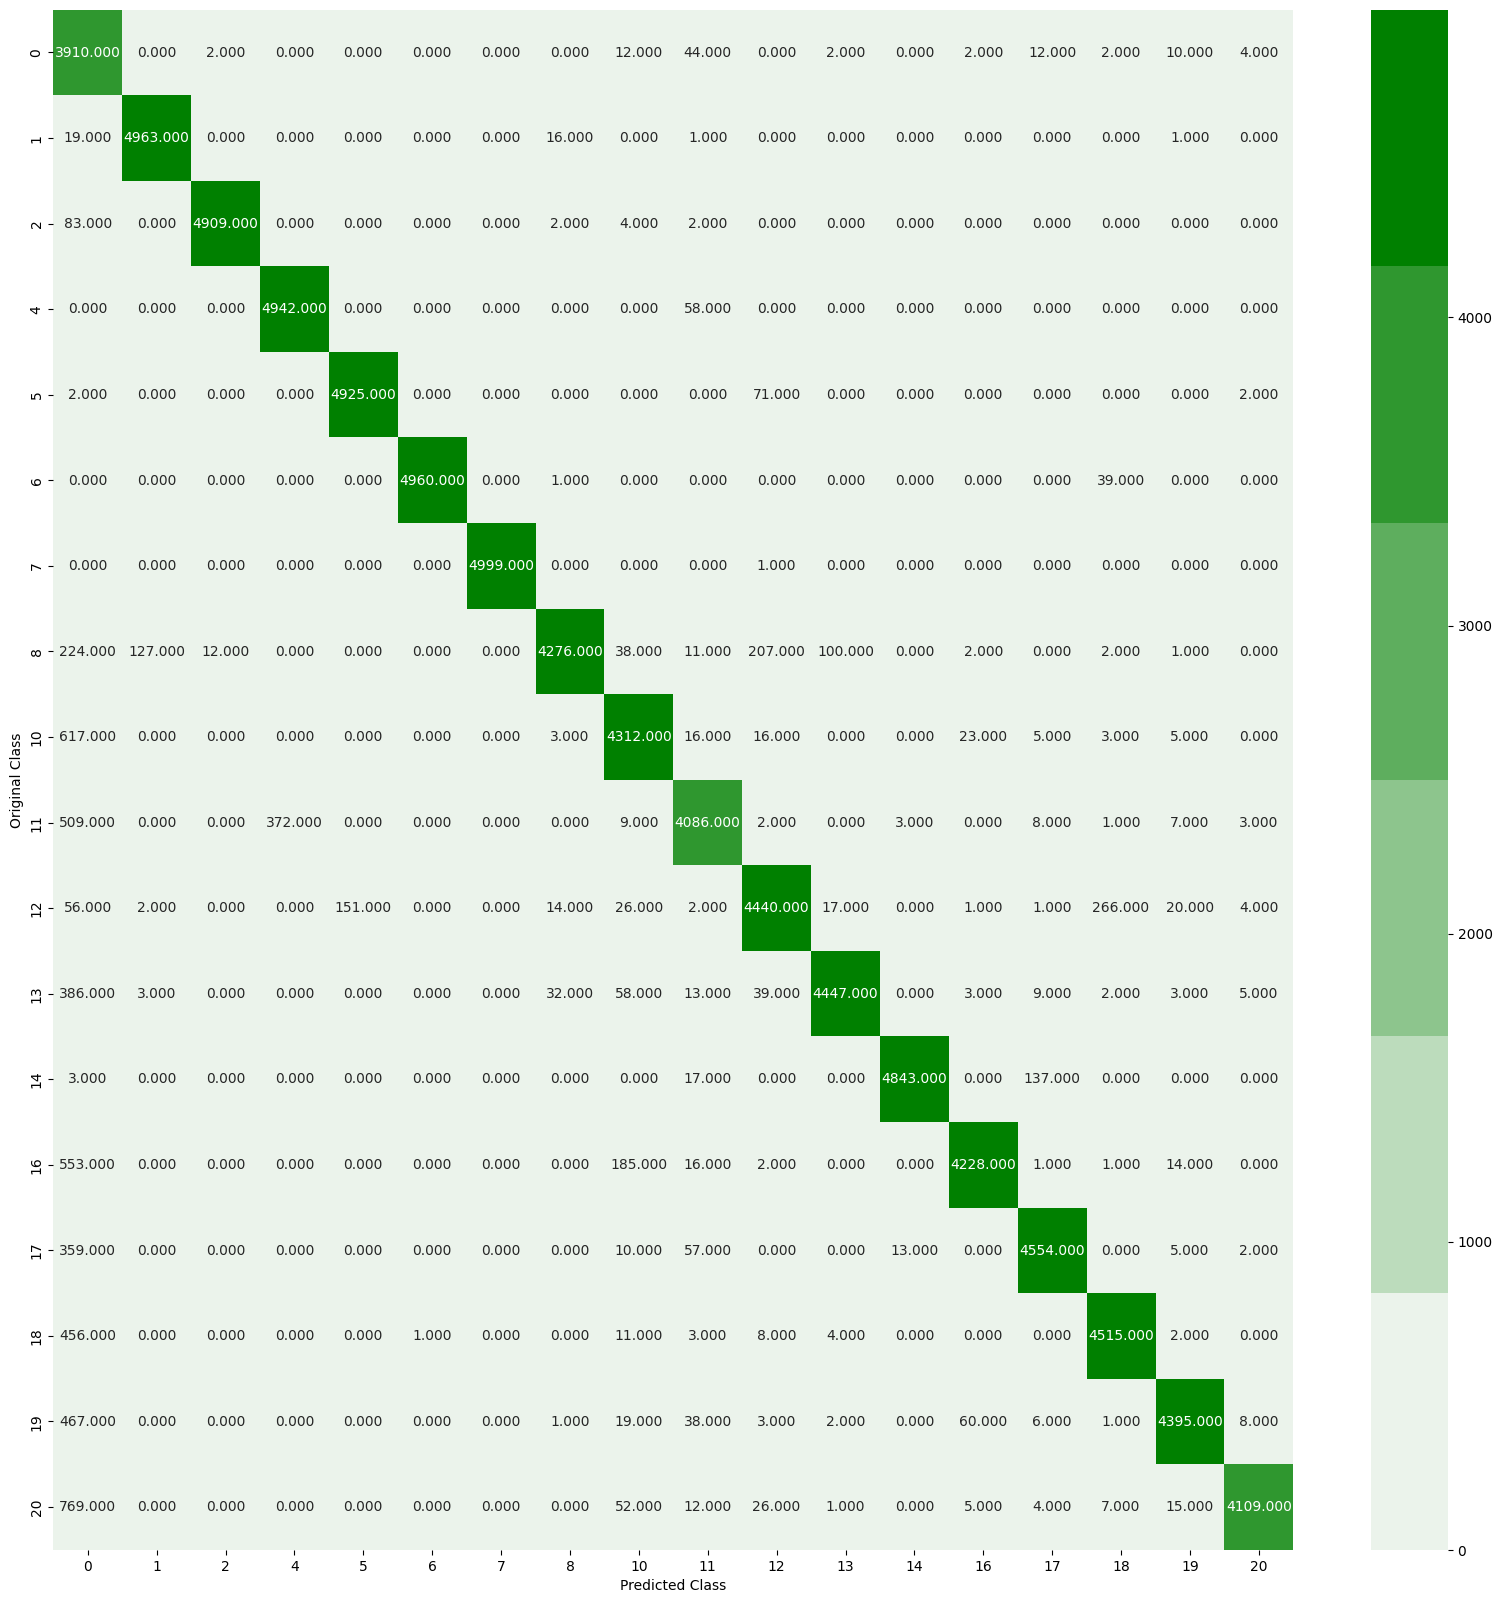

-------------------------------------------------- Precision matrix --------------------------------------------------


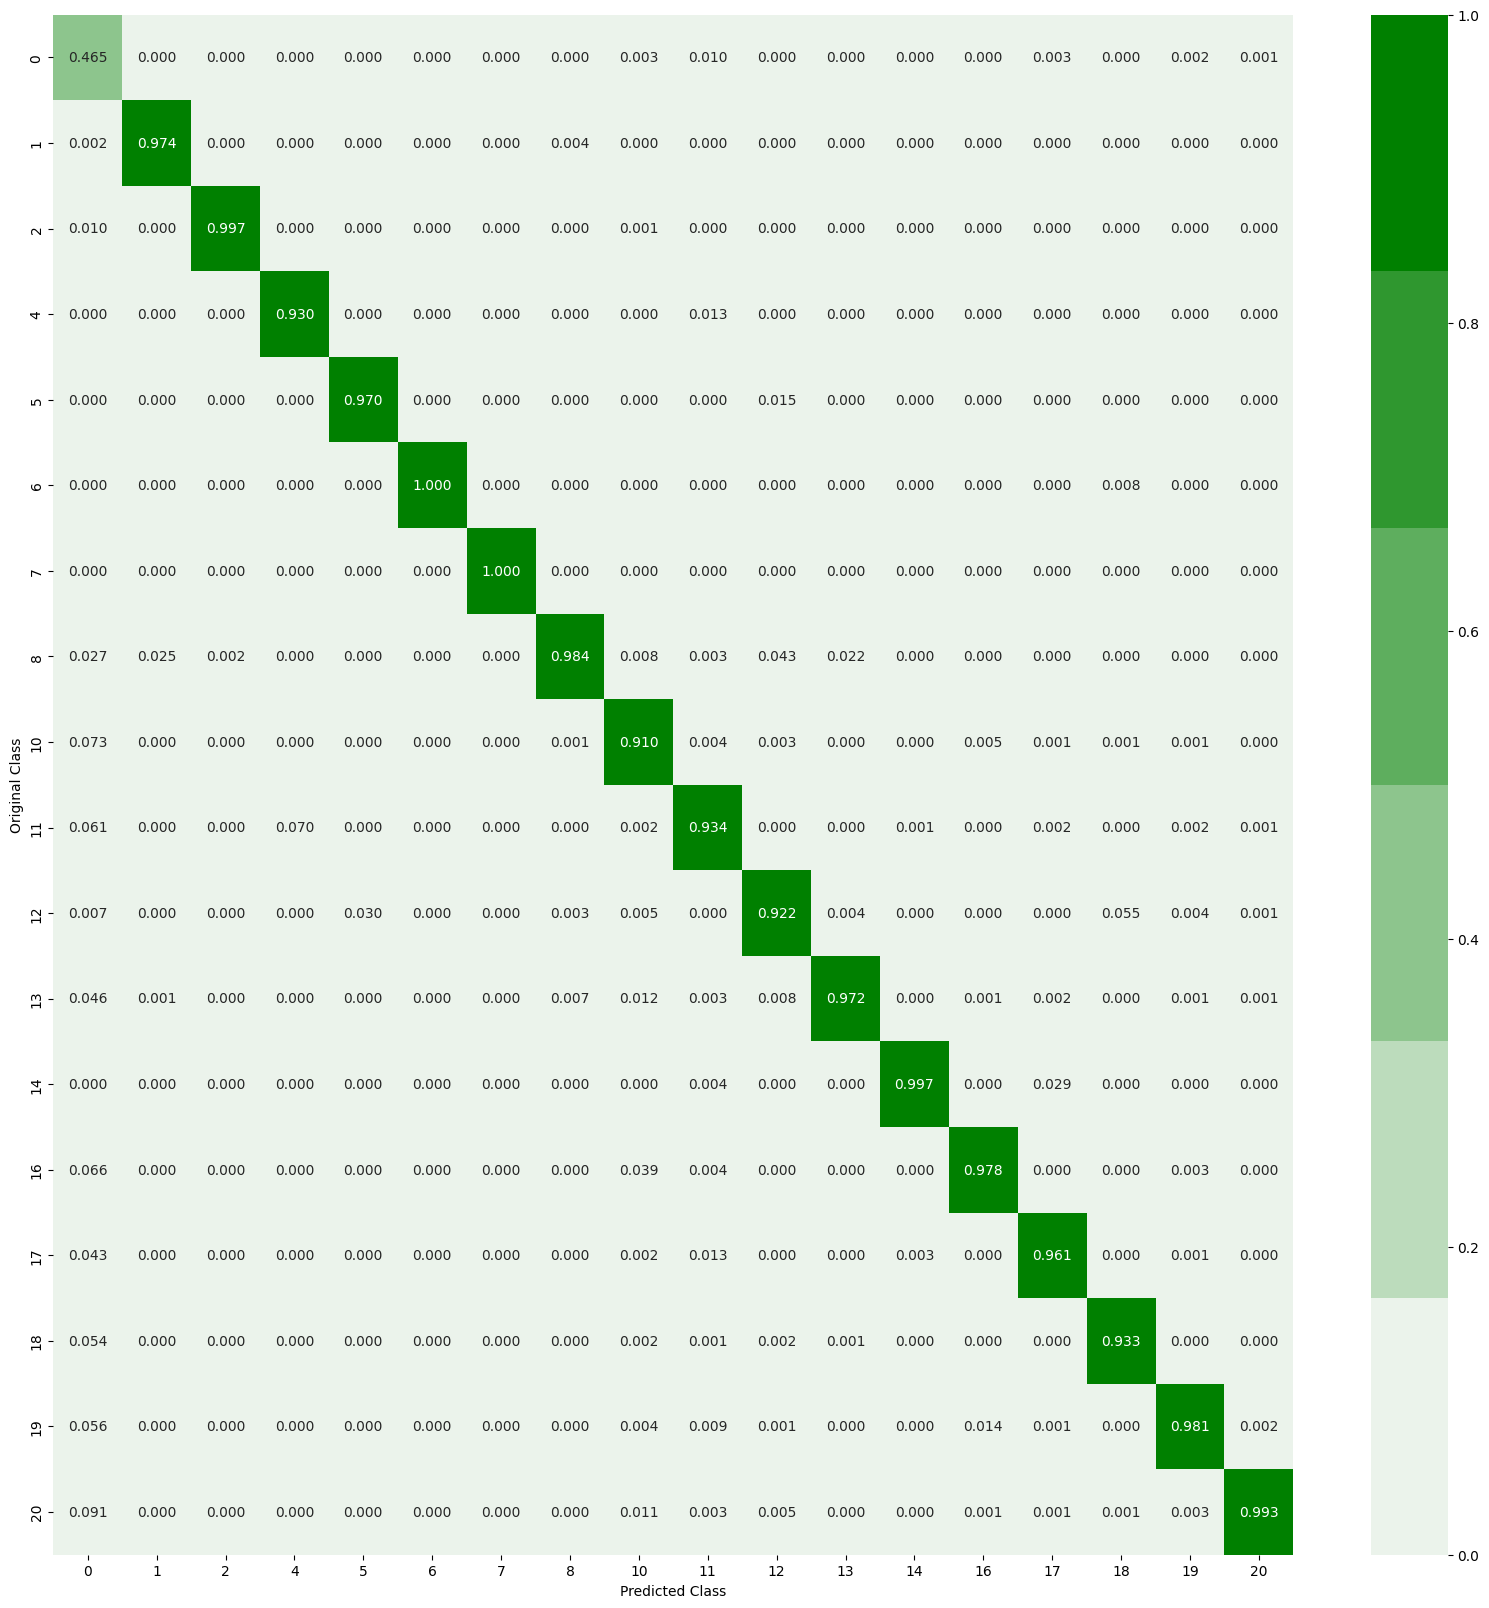

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


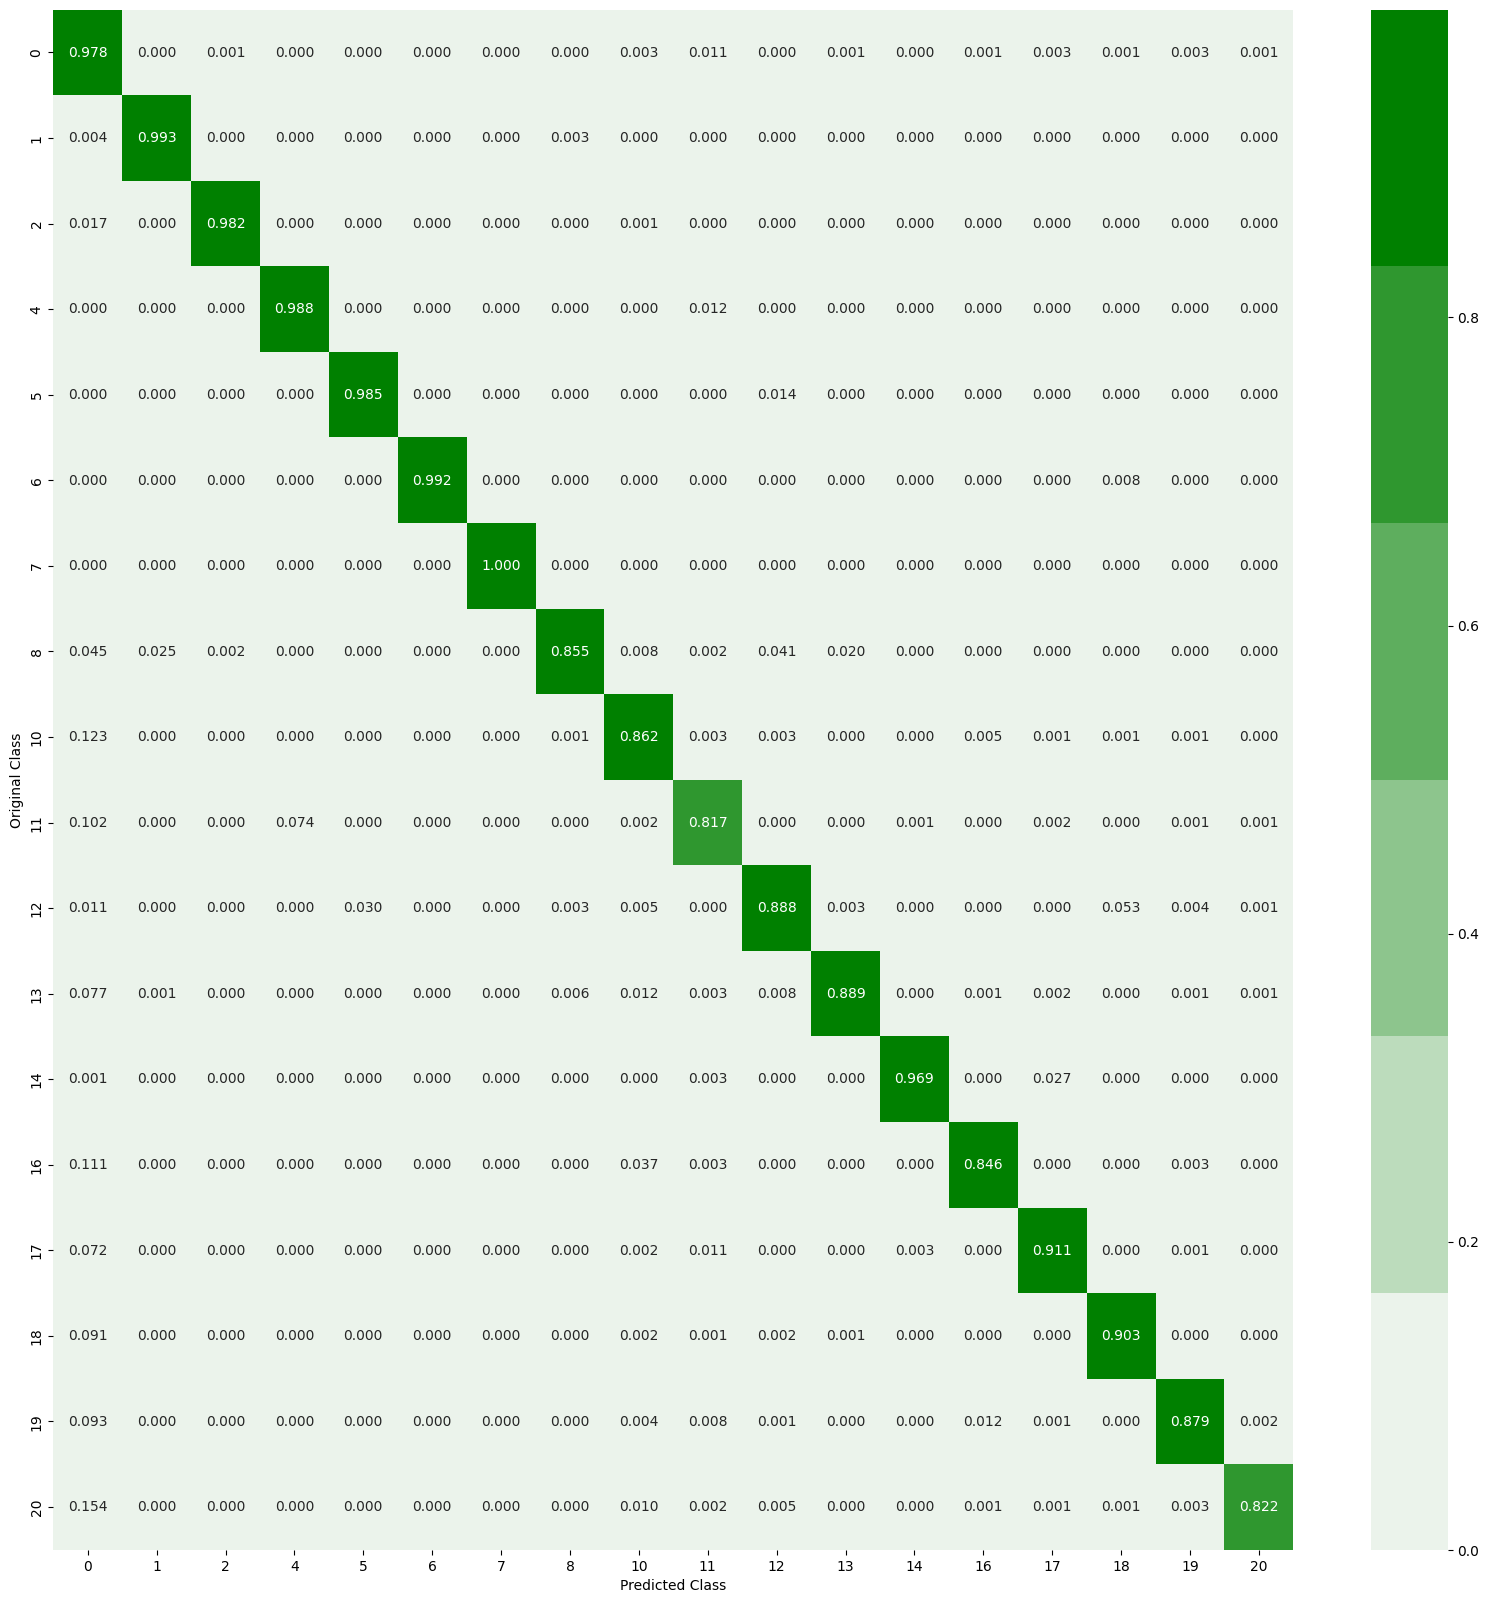

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

# Obtener las probabilidades predichas del modelo
predict_y_prob = model.predict(test_norm)

# Convertir las probabilidades predichas en clases
predict_y_classes = np.argmax(predict_y_prob, axis=1)

predict_y_multilabel = np.argmax(predict_y_prob, axis=1)

# Convertir las clases predichas a un formato multilabel-indicator
#predict_y_multilabel = label_binarize(predict_y_classes, classes=np.unique(y_test_encoded))

# Llamar a la función plot_confusion_matrix con las etiquetas verdaderas y las predicciones
plot_confusion_matrix(np.argmax(y_test_encoded.toarray(), axis=1), predict_y_classes)


### Partial Dependence Plot (PDP)

El gráfico de dependencia parcial PDP son gráficos que nos ayudan a entender cómo una variable específia afecta a las predicciones de nuestro modelo.

-  Para construir una PDP debemos elegir la característica de entrada que será la que queramos analizar.
- Variamos su valor, es decir mantenemos constantes todas las demás variables y modificamos gradualmente el valor de la variable seleccionada.
- Calculamos las predicciones, es decir, para cada valor de la variable calculamos las predicciones del modelo.
- Graficamos estos resultados. Representamos en un gráfico cómo cambian las predicciones a medida que varia la variable

El eje x representa los valores de la variable (característica) seleccionada, y el eje y muestra las predicciones del modelo.

Una vez que tengamos las gráficas dibujadas podremos analizarlas para ver como se comportan. Si la curva es lineal, significa que la relación entre la variable y la predicción es aditiva. Es decir no hay muchas interacciones con otras características. Mientras que si no ocurre esto, podría significar que la característica es dependiente de otras características del conjunto.

Las PDP asumen que las variables no están correlacionadas, pero si hay variables correlacionadas los resultados puedes resultar engañosos.

En nuestro caso vamos a observar constantes picos y oscilaciones brutas, esto nos va a indicar que nuestas características tienen interacción entre ellas, además si dos características interactúan de manera no lineal entre ellas podría resultar en este tipo de gráficas.

En un segundo ejemplo eliminaremos las características que estén correlacionadas entre ellas para poder volver a analizarlas y observar de forma más exacta que está sucediendo.

Para poder abordar las PDP de forma matemática debemos presentar algunas definiciones.

- $\textit{Modelo de regresión}$. Un modelo de regresión es un enfoque estadístico usado para modelar y analizar la relación entre una o más variables independientes (características) y una variablbe dependiente continua. La idea principal de este modelo es predecir o estimar el valor de la variable dependiente en función de los valores de las variables independientes.
- En este modelo, podemos expresar la relación entre las variables independientes y la dependiente mediante una función matemática. Esta función se usa para realizar las predicciones sobre la variable dependiente en funcionn de los valores de las variables independientes.

Existen varios tipos de modelos de regresión, cada uno de los cuales usa diferentes funciones matemáticas para modelar la relación entre las varibales. Entre ellos encontramos la regresión lineal, regresión polinómica, regresión logística y refrfesión de árbol de decisiones. 


Ahora supongamos que tenemos un modelo de regresión $f(x)$ que predice una variable de respuesta $Y$ en función de $p$ características de entrada $X=(X_1, X_2, X_3,....)$

El objetivo que se busca a través de las PDP es visualizar como cambia la predicción del modelo $f(x)$ cuando variamos una o varias características de entrada $X_S$, manteniendo el resto de características constantes o promediadas.


La función de la dependencia parcial $PD_S(x_S)$ para una característica $X_S$ se define como 
$$PD_S(x_S)=E_{X_C}[f(x_S, X_C)] = \int f(x_S, x_c)d\mathbb{P}(X_C)$$

Donde 

- $PD_S(x_S)$ es la función dependencia parcial para las características $X_S$
- $E_{X_C}$ es el valor esperado sobre todas las características $X_c$ excepto $X_S$.
- $f(x)$ es el modelo de aprendizaje automático
- $x_S$ son las características para las cuales se debe trazar la función de dependencia parcia
- $x_c$ son el resto de características usadas en el modelo $f(x)$ 

Normalmente hay una o dos características en el conjunto $S$. Las características en $S$ son aquellas para las cuales queremos saber el efecto en la predicción. Los vectores $x_S$ y $x_C$ combinados forman el espacio total de características $x$

La función de dependencia parcial funciona marginalizando la salida del modelo de aprendizaje automático sobre la distribución de las características en el conjunto $C$, de modo que la función muestre la relación entre las características en el conjunto $S$ que nos interesan y el resultado predicho. Al marginalizar sobre las otras características, obtenemos una función que depende solo de las características en $S$, incluidas las interacciones con otras características.

La función $f_S(x_S)$ se estima calculando promedios en los datos de entrenamiento, también conocido como método de Monte Carlo:
$$f_S=\frac{1}{n}\sum_{i=1}^n f(x_S,x_C^{(i)})$$
Esta función nos dice, para un valor dado de las características $S$, cuál es el efecto marginal promedio en la predicción. En esta fórmula, $x_C^{(i)}$ son los valores reales de las características del conjunto de datos para las características en las que no estamos interesados, y $n$ es el número de instancias en el conjunto de datos. Para que este método funcione bien, se debe suponer que las características en $C$ no están correlacionadas con las características en $S$, de otra forma los resultados pueden verse afectados.

En el caso de la clasificación, donde el modelo de aprendizaje automático produce probabilidades, el gráfico de dependencia parcial muestra la probabilidad de cierta clase dada diferentes valores para las características en $S$. Una forma fácil de manejar múltiples clases es dibujar una línea o gráfico por clase.

El gráfico de dependencia parcial es un método global: considera todas las instancias y proporciona una declaración sobre la relación global de una característica con el resultado predicho.

In [14]:
import shap

PDP - feature  xmeas_1
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 534us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 545us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 523us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 519us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 517us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 515us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 527us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 524us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 518us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 535us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 534us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 517us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 514us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 516us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 517us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 522us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 529us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 516us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 520us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 529us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4

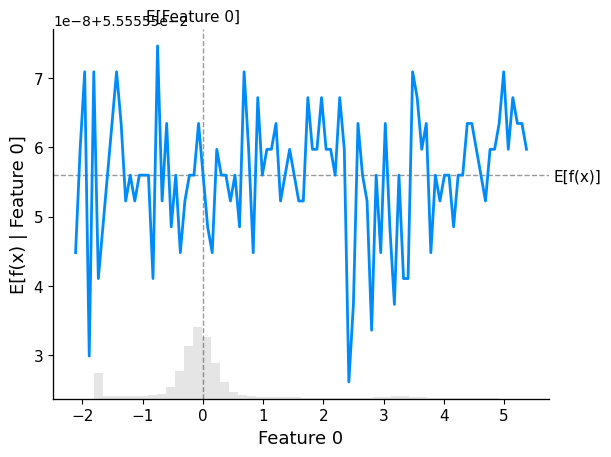

PDP - feature  xmeas_2
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 550us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 528us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 528us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 527us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 519us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 516us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 521us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 513us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 510us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 531us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 508us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 529us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 521us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 517us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 516us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 523us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 506us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 550us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 508us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 512us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 513us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4

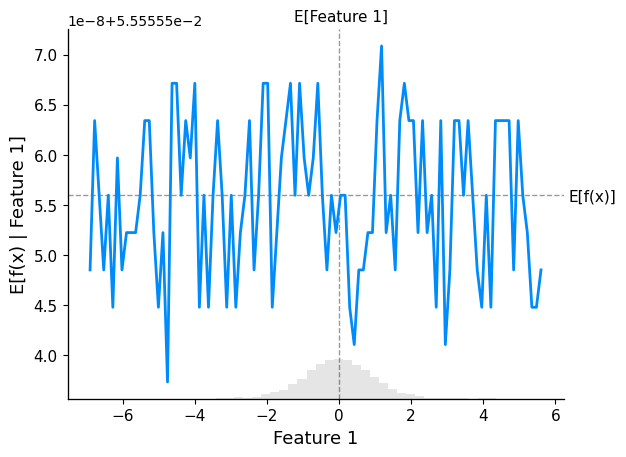

PDP - feature  xmeas_3
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 526us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 513us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 512us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 517us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 578us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 509us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 516us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 506us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 509us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 505us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 514us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 509us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 512us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 505us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 517us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 516us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 542us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 518us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 525us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 513us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 527us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4

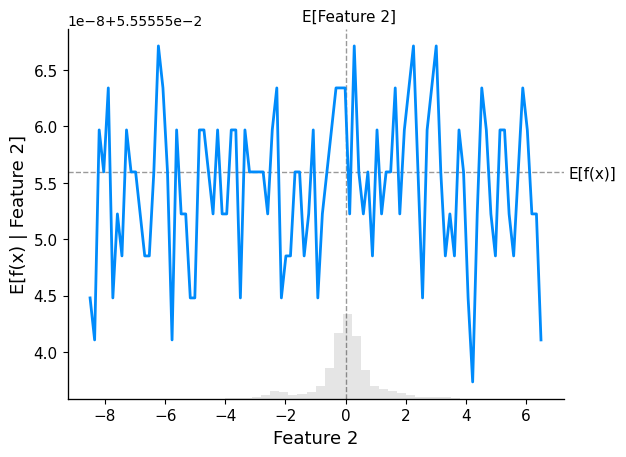

In [23]:
list_column=list(tr)
for i in range(0, 52):
    print('PDP - feature ', list_column[i])
    shap.plots.partial_dependence(
    #    i, lambda x: model.predict(x)[0], train_norm, ice=False,
        i, model.predict, train_norm, ice=False,
        model_expected_value=True, feature_expected_value=True
    )

### Resultado

El número realista de características en una función de dependencia parcial es dos. Esto se debe a la representación bidimensional y de nuestra incapacidad para imaginar más de tres dimensiones. En nuestro caso estamos realizando el análisis con una característica.

Un concepto a definir en este caso es el efecto heterogéneo. En el contexto de los modelos predictivos, se refiere a una situación en la que el efecto de una característica en la variable objetivo varia entre diferentes subgrupos de datos. Es decir que una característica sea dependiente del valor de otra. 

Cuando nuestras características están correlacionadas, tenedemos a realizar un análisis incorrecto de nuestras gráficas y los efectos heterogéneos pueden estar ocultos ya que las PDP solo muestran los efectos marginales promedios. Para evitar este problema trabajaremos también con los gráficos de Efecto Local Acumulado (ALE) que trabajan con la distribución condicional en lugar de la marginal.


Vamos a analizar que está sucediendo en nuestro caso concreto. En nuestro trabajo queremos interpretar el efecto marginal de cada una de las características sobre cada una de las características de nuestro modelola variable predicha de nuestro modelo. Para ello una vez tenemos el modelo entrenado, hemos hecho uso de la librería shap que contiene una función que se encarga de pintar las gráficas de dependencia parcial.

Como se puede observar en cada una de las gráficas anteriores, obtenemos una curva muy oscilatoria, con muchos picos, es decir no sigue ningún patrón de los establecidos, es decir para dos valores muy cercanos no hay forma de saber que valor se va a obtener (como se va a comportar la curva). Esto también nos dice cosas, pueden estar pasando dos cosas. Una de ellas es que como se ha comentado antes las variables estén correlacionadas y por tanto estamos pintando valores irreales para los valores de la característica que estamos pintando. El otro motivo que puede estar haciendo que no seamos capaces de interpretar estas gráficas es debido a que las variables sean dependientes, podríamos decir que la característica que analizamos sea dependiente con alguna del conunto restante pero como esto pasa para cada una de las características tendríamos que la gran mayoría de las características tienen dependencia entre ellas, lo cual es bastante posible dada la característica de nuestro conjunto de datos.

Para intentar comprender un poco mejor que está sucediendo vamos a dibujar la matriz de correlación para ver si nuestras características tienen correlación entre ellas, y según observemos consideraremos eliminarlas del modelo y entrenarlo para ver como se comportan las gráficas PDP sin esta correlación.